# Fully feature-engineered dataset

In [9]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/charlesoneill/DataspellProjects/bushfireanalysis/input/bushfire_clean.csv")
df.drop(['Year.1', 'Year', 'Unnamed: 0'], axis=1, inplace=True)
df.head()

,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug-Jan,Sep-Jan,Oct-Jan,ha_burnt
0,56.9,67.8,280.3,71.6,244.9,62.6,75.0,41.0,89.4,31.4,54.0,42.0,784.1,727.2,659.4,0
1,239.9,52.5,74.4,517.2,172.2,133.4,158.2,62.8,100.3,270.1,4.1,69.7,1189.6,949.7,897.2,0
2,109.7,86.5,21.9,10.4,114.1,138.7,50.4,387.8,238.6,211.1,264.8,67.2,481.3,371.6,285.1,0
3,269.2,24.8,62.4,41.5,279.1,18.2,37.0,171.7,139.6,78.1,407.5,9.5,695.2,426.0,401.2,0
4,25.7,15.1,86.3,74.2,38.0,36.8,22.7,8.4,85.1,42.6,236.3,97.8,276.1,250.4,235.3,366000


In [10]:
df.drop(columns=['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 
                 'Mar', 'Apr', 'May', 'Jun', 'Jul'], inplace=True)
df.head()

,Aug-Jan,Sep-Jan,Oct-Jan,ha_burnt
0,784.1,727.2,659.4,0
1,1189.6,949.7,897.2,0
2,481.3,371.6,285.1,0
3,695.2,426.0,401.2,0
4,276.1,250.4,235.3,366000


In [11]:
# exponential moving average HA burnt
df['EMA_ha_burnt'] = df.ha_burnt.ewm(alpha=0.1, adjust=False).mean()
# simple moving average HA burnt
df['SMA_ha_burnt'] = df.ha_burnt.rolling(15, min_periods=1).mean()
# exponential moving standard deviation HA burnt
df['EMA_ha_burnt_std'] = df.ha_burnt.ewm(alpha=0.1, adjust=False).std()
# total burnt in last 15 years
df['sum_ha_burnt_15'] = df.ha_burnt.rolling(15, min_periods=1).sum()

# exponential moving average Dennison index (Oct-Jan)
df['EMA_Oct-Jan'] = df['Oct-Jan'].ewm(alpha=0.4, adjust=False).mean()
# simple moving average Dennison index
df['SMA_Oct-Jan'] = df['Oct-Jan'].rolling(15, min_periods=1).mean()
# exponential moving standard deviation Dennison index
df['EMA_Oct-Jan_std'] = df['Oct-Jan'].ewm(alpha=0.4, adjust=False).std()
# total rain in last 15 years
df['sum_Oct-Jan'] = df['Oct-Jan'].rolling(15, min_periods=1).sum()

In [12]:
def years_since_million(df):
    lst = []
    count = 0
    for i in range(len(df)):
        lst.append(count)
        if df.ha_burnt.iloc[i] > 1000000:
            count = 0
        else:
            count+=1
    return lst

df['years_since_million'] = years_since_million(df)
df.head()

,Aug-Jan,Sep-Jan,Oct-Jan,ha_burnt,EMA_ha_burnt,SMA_ha_burnt,EMA_ha_burnt_std,sum_ha_burnt_15,EMA_Oct-Jan,SMA_Oct-Jan,EMA_Oct-Jan_std,sum_Oct-Jan,years_since_million
0,784.1,727.2,659.4,0,0.0,0.0,NaN,0.0,659.40000,659.400,NaN,659.4,0
1,1189.6,949.7,897.2,0,0.0,0.0,0.000000,0.0,754.52000,778.300,168.149993,1556.6,1
2,481.3,371.6,285.1,0,0.0,0.0,0.000000,0.0,566.75200,613.900,305.756319,1841.7,2
3,695.2,426.0,401.2,0,0.0,0.0,0.000000,0.0,500.53120,560.725,245.787638,2242.9,3
4,276.1,250.4,235.3,366000,36600.0,73200.0,149480.148816,366000.0,394.43872,495.640,240.918888,2478.2,4


In [13]:
df = df.fillna(0)
df.head()

,Aug-Jan,Sep-Jan,Oct-Jan,ha_burnt,EMA_ha_burnt,SMA_ha_burnt,EMA_ha_burnt_std,sum_ha_burnt_15,EMA_Oct-Jan,SMA_Oct-Jan,EMA_Oct-Jan_std,sum_Oct-Jan,years_since_million
0,784.1,727.2,659.4,0,0.0,0.0,0.000000,0.0,659.40000,659.400,0.000000,659.4,0
1,1189.6,949.7,897.2,0,0.0,0.0,0.000000,0.0,754.52000,778.300,168.149993,1556.6,1
2,481.3,371.6,285.1,0,0.0,0.0,0.000000,0.0,566.75200,613.900,305.756319,1841.7,2
3,695.2,426.0,401.2,0,0.0,0.0,0.000000,0.0,500.53120,560.725,245.787638,2242.9,3
4,276.1,250.4,235.3,366000,36600.0,73200.0,149480.148816,366000.0,394.43872,495.640,240.918888,2478.2,4


## Random forest

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

df = df.astype(float)

# split the data intro train and test
df_train, df_test = df.iloc[:45], df.iloc[45:]
X_train, y_train = df_train.drop(columns=['ha_burnt']), df_train.ha_burnt
X_test, y_test = df_test.drop(columns=['ha_burnt']), df_test.ha_burnt

# train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# get the predictions (clamp at 0)
y_pred = model.predict(X_test)
y_pred = [max(0, x) for x in y_pred]
rmse = np.sqrt(mse(y_pred, y_test))
rmse

1155211.7072063747

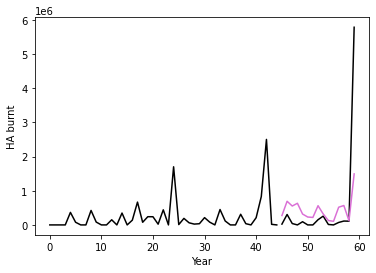

In [15]:
x = [x for x in range(45, 60, 1)]
plt.plot(y_train, color="black")
plt.plot(y_test, color="black")
plt.plot(x, y_pred, color="orchid")
plt.xlabel('Year')
plt.ylabel('HA burnt')
plt.savefig("feature.png", dpi=300)
plt.show()

In [16]:
rmse = np.sqrt(mse(y_pred[:-1], y_test[:-1]))
rmse

341027.2755115889

In [28]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
X, y = df.drop(columns=['ha_burnt']), df.ha_burnt
fi = rf_feat_importance(model, X)
fi[:10]

,cols,imp
11,years_since_million,0.227383
2,Oct-Jan,0.170487
5,EMA_ha_burnt_std,0.144456
3,EMA_ha_burnt,0.086596
1,Sep-Jan,0.081539
0,Aug-Jan,0.074586
4,SMA_ha_burnt,0.057901
7,EMA_Oct-Jan,0.051438
6,sum_ha_burnt_15,0.038982
9,EMA_Oct-Jan_std,0.030272


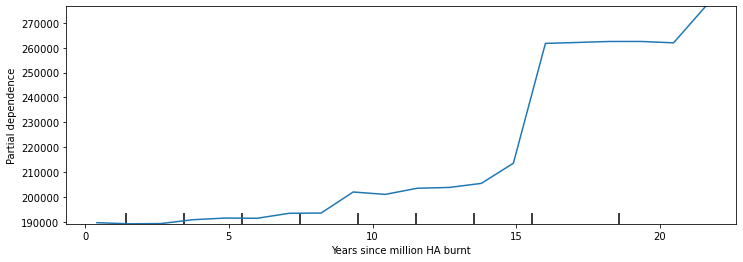

In [30]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(model, X, ['years_since_million'],
                        grid_resolution=20, ax=ax);
plt.xlabel('Years since million HA burnt')
plt.savefig("partialdep.png", dpi=300)

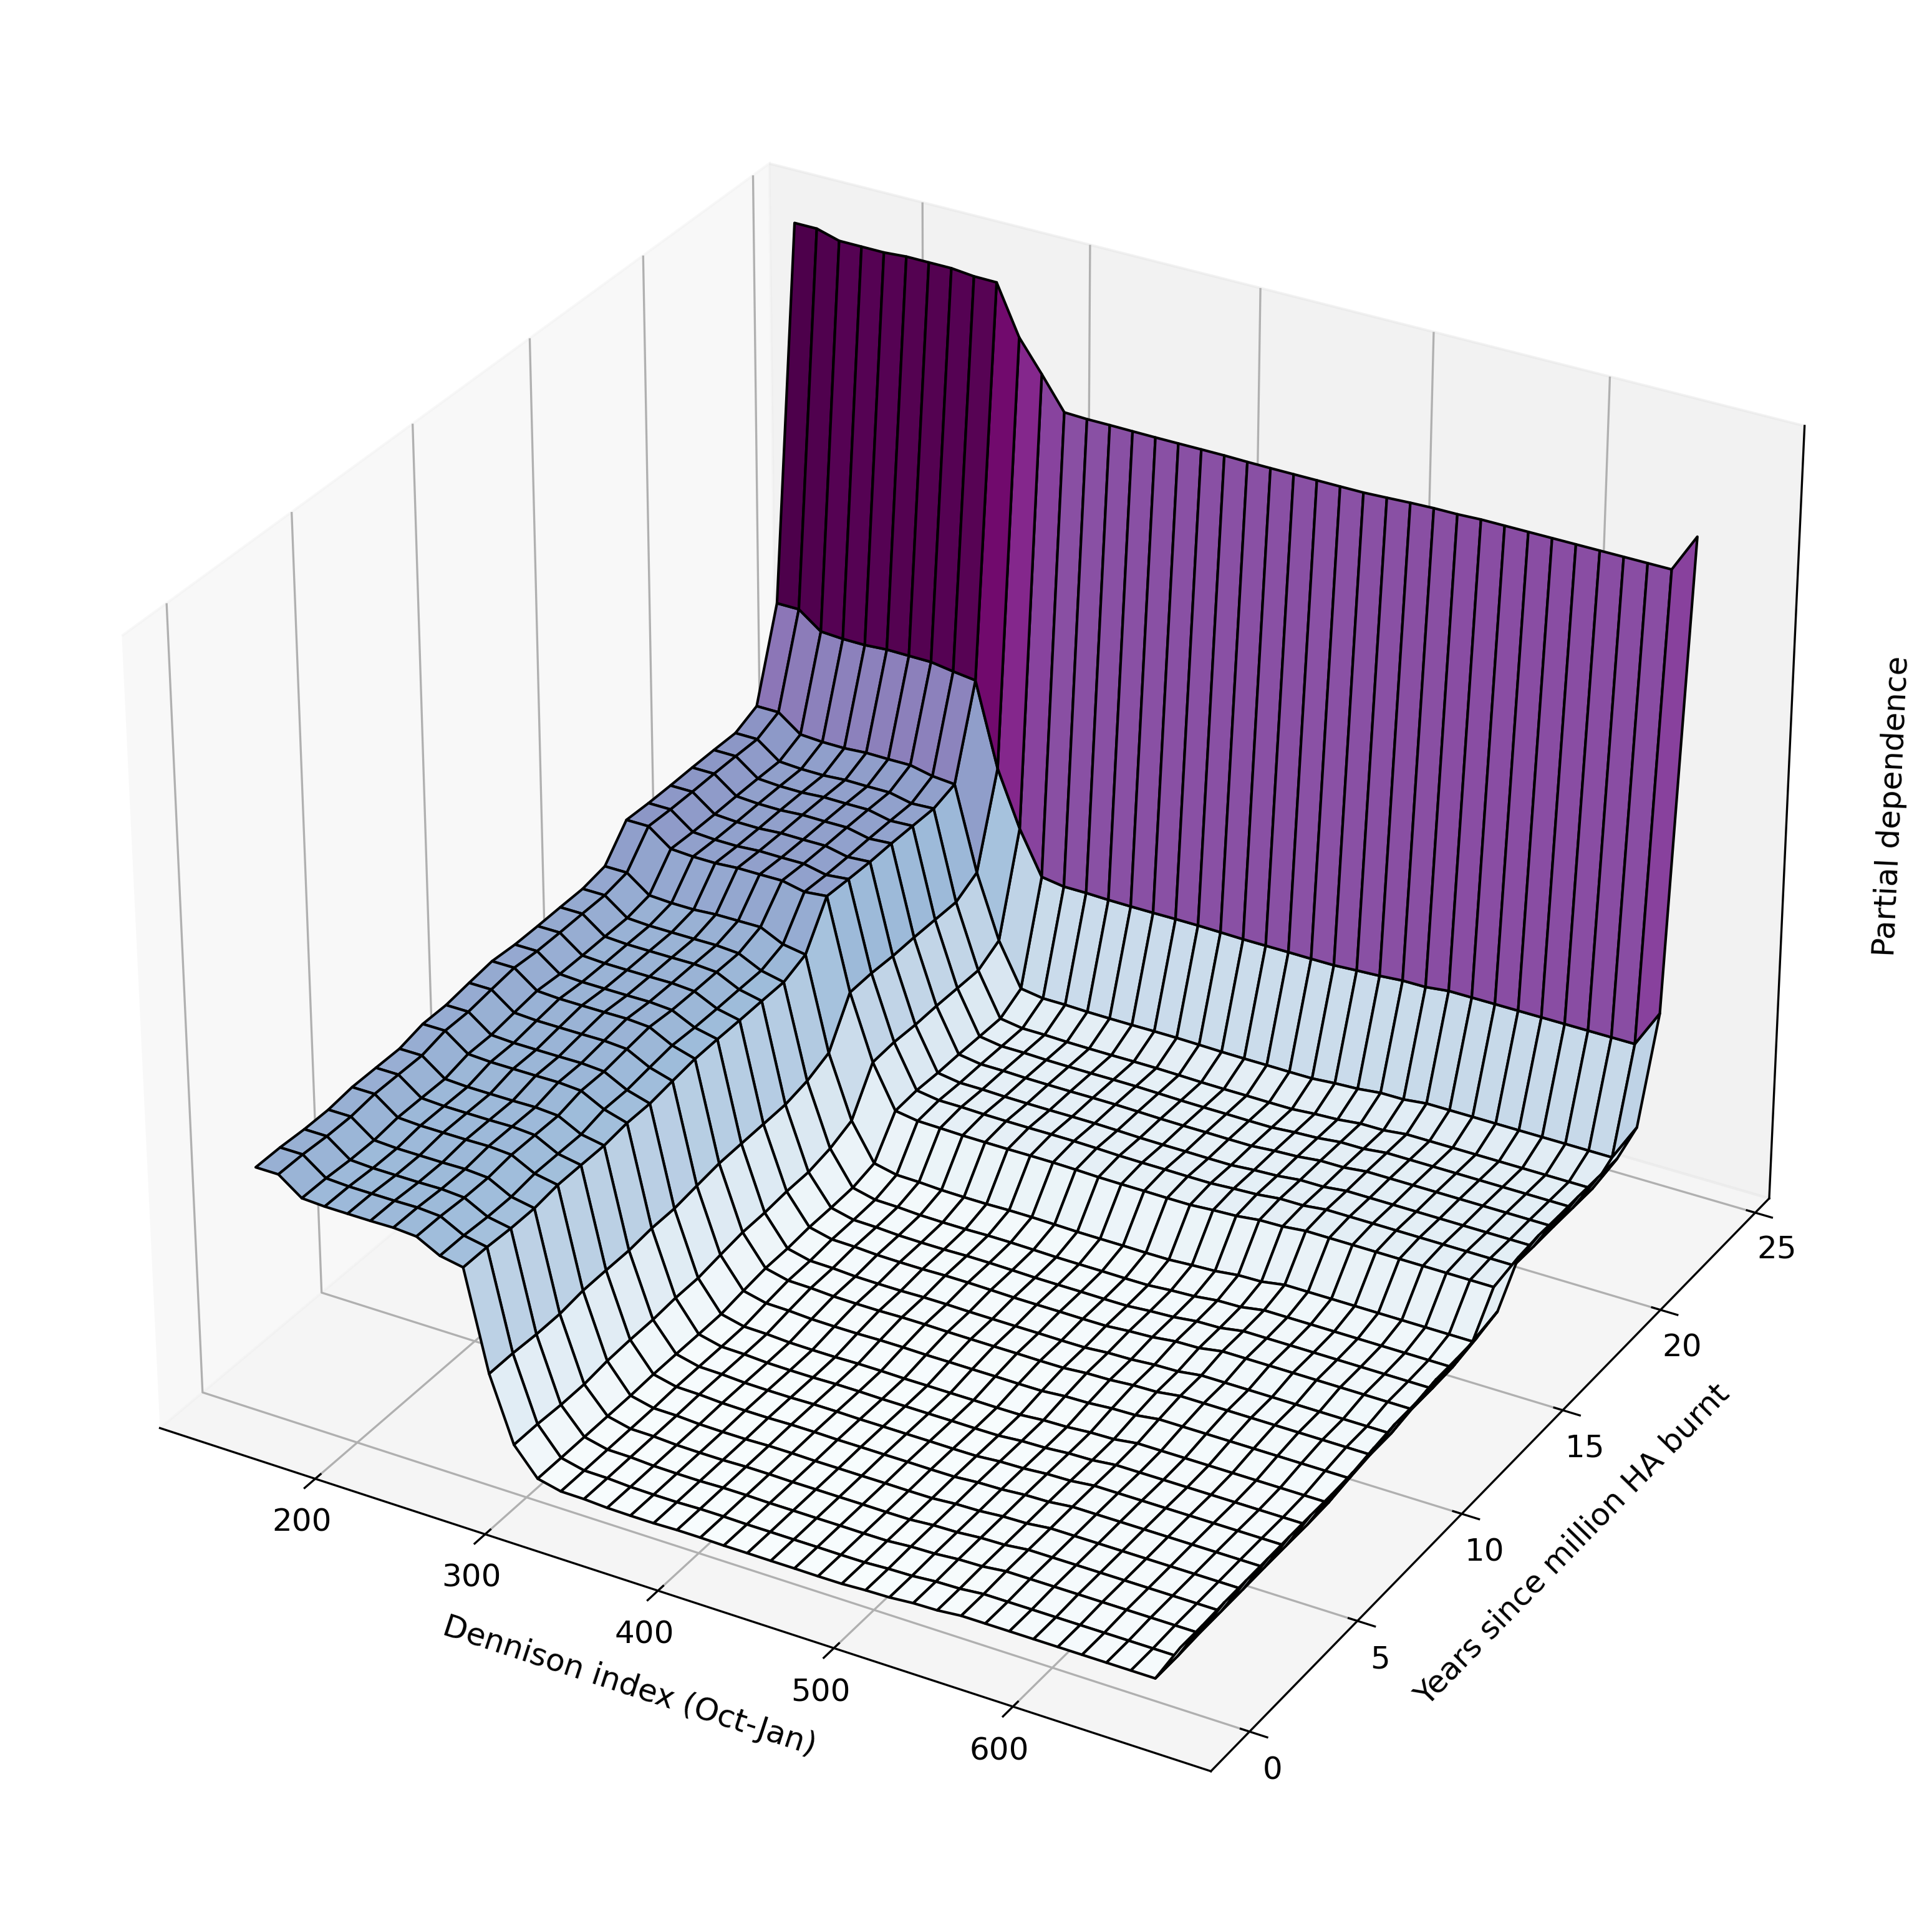

In [31]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import fetch_california_housing

plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(12,10), dpi=300)
features = ('Oct-Jan', 'years_since_million')
pdp, axes = partial_dependence(model, X, features=features,
                               grid_resolution=40)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel('Dennison index (Oct-Jan)')
ax.set_ylabel('Years since million HA burnt')
ax.set_zlabel('Partial dependence')
ax.zaxis.set_ticks([])
ax.tick_params(axis='both', which='major', pad=0)
#  pretty init view
#ax.view_init(elev=22, azim=122)
#plt.colorbar(surf)
plt.subplots_adjust(top=0.9)
plt.savefig("3dpartialdep.png", dpi=300)
plt.show()

## RNN

In [37]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

In [35]:
df_nn = df.astype(float)
dep_var = 'ha_burnt'
df_nn.ha_burnt = df_nn.ha_burnt + 10
df_nn.head()

,Aug-Jan,Sep-Jan,Oct-Jan,ha_burnt,EMA_ha_burnt,SMA_ha_burnt,EMA_ha_burnt_std,sum_ha_burnt_15,EMA_Oct-Jan,SMA_Oct-Jan,EMA_Oct-Jan_std,sum_Oct-Jan,years_since_million
0,784.1,727.2,659.4,10.0,0.0,0.0,0.000000,0.0,659.40000,659.400,0.000000,659.4,0.0
1,1189.6,949.7,897.2,10.0,0.0,0.0,0.000000,0.0,754.52000,778.300,168.149993,1556.6,1.0
2,481.3,371.6,285.1,10.0,0.0,0.0,0.000000,0.0,566.75200,613.900,305.756319,1841.7,2.0
3,695.2,426.0,401.2,10.0,0.0,0.0,0.000000,0.0,500.53120,560.725,245.787638,2242.9,3.0
4,276.1,250.4,235.3,366010.0,36600.0,73200.0,149480.148816,366000.0,394.43872,495.640,240.918888,2478.2,4.0


In [38]:
cont_nn,cat_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var)
train_idx = [x for x in range(0, 45)]
valid_idx = [x for x in range(45, 60)]
splits = (list(train_idx), list(valid_idx))
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)
dls = to_nn.dataloaders(8)
y = to_nn.train.y
y.min(),y.max()

(10.0, 2500010.0)

SuggestedLRs(valley=0.019054606556892395)

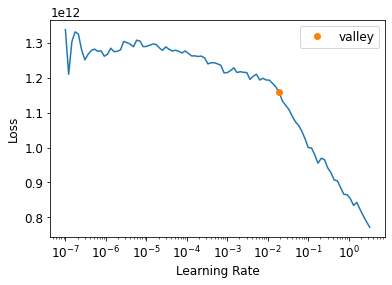

In [40]:
learn = tabular_learner(dls, y_range=(0,2500010.0), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)
learn.lr_find()

In [41]:
learn.fit_one_cycle(10, 0.009)

epoch,train_loss,valid_loss,time
0,1338151796736.000000,2285154598912.000000,00:00
1,1285217976320.000000,1362749816832.000000,00:00
2,1177828065280.000000,2583274717184.000000,00:00
3,1071267577856.000000,1531490074624.000000,00:00
4,932214013952.000000,1229945962496.000000,00:00
5,807947272192.000000,940373770240.000000,00:00
6,685805600768.000000,1014667476992.000000,00:00
7,588413534208.000000,1077344141312.000000,00:00
8,508863905792.000000,1089935769600.000000,00:00
9,445290512384.000000,1196788809728.000000,00:00


In [43]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

preds,targs = learn.get_preds()
r_mse(preds,targs)

1093978.432021

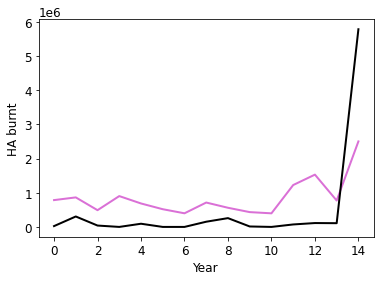

In [44]:
plt.plot(preds, color='orchid', linewidth=2)
plt.plot(targs, color='black', linewidth=2)
plt.xlabel('Year')
plt.ylabel('HA burnt')
plt.savefig("lstmpred.png", dpi=300)
plt.show()

## Sensitivity analysis

In [17]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
import math

len(df.columns)

13

In [18]:
problem = {
    'num_vars': 12,
    'names': ['Aug-Jan', 'Sep-Jan', 'Oct-Jan', 'EMA_ha_burnt',
       'SMA_ha_burnt', 'EMA_ha_burnt_std', 'sum_ha_burnt_15', 'EMA_Oct-Jan',
       'SMA_Oct-Jan', 'EMA_Oct-Jan_std', 'sum_Oct-Jan', 'years_since_million'],
    'bounds': [[0, 1000], [0, 1000], [0, 1000],
               [0, 6000000], [0, 6000000], [0, 2000000],
               [0, 6958000], [0, 800], [0, 900], [0,500],
               [0, 10000], [0, 30]]
}

In [19]:
param_values = saltelli.sample(problem, 1024)
param_values.shape

(26624, 12)

In [21]:
Y = np.zeros([param_values.shape[0]])
for i in range(len(param_values)):
    Y[i] = model.predict(param_values[i].reshape(1, -1))

In [22]:
Si = sobol.analyze(problem, Y)

In [23]:
print(Si['S1'])

[0.0206546  0.03370995 0.07556011 0.02540352 0.01426699 0.20372022
 0.0287674  0.04818598 0.01075063 0.01727817 0.00471102 0.51463997]


In [24]:
print(Si['ST'])

[0.02251614 0.03458631 0.08203361 0.02115729 0.01236434 0.20569378
 0.0300872  0.04766706 0.00953748 0.01874365 0.00322855 0.53279321]


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

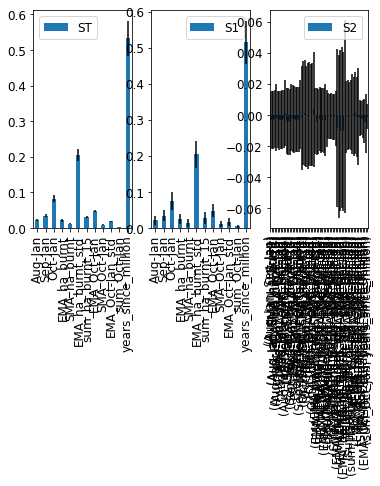

In [33]:
total_Si, first_Si, second_Si = Si.to_df()
Si.plot()

In [34]:
plt_df = total_Si.sort_values('ST', ascending=False)
print(plt_df.to_latex(index=True))  

\begin{tabular}{lrr}
\toprule
{} &        ST &   ST\_conf \\
\midrule
years\_since\_million &  0.532793 &  0.048887 \\
EMA\_ha\_burnt\_std    &  0.205694 &  0.017257 \\
Oct-Jan             &  0.082034 &  0.009689 \\
EMA\_Oct-Jan         &  0.047667 &  0.004076 \\
Sep-Jan             &  0.034586 &  0.005002 \\
sum\_ha\_burnt\_15     &  0.030087 &  0.002834 \\
Aug-Jan             &  0.022516 &  0.002469 \\
EMA\_ha\_burnt        &  0.021157 &  0.004162 \\
EMA\_Oct-Jan\_std     &  0.018744 &  0.001960 \\
SMA\_ha\_burnt        &  0.012364 &  0.002480 \\
SMA\_Oct-Jan         &  0.009537 &  0.001156 \\
sum\_Oct-Jan         &  0.003229 &  0.000324 \\
\bottomrule
\end{tabular}

